In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

import blackjax

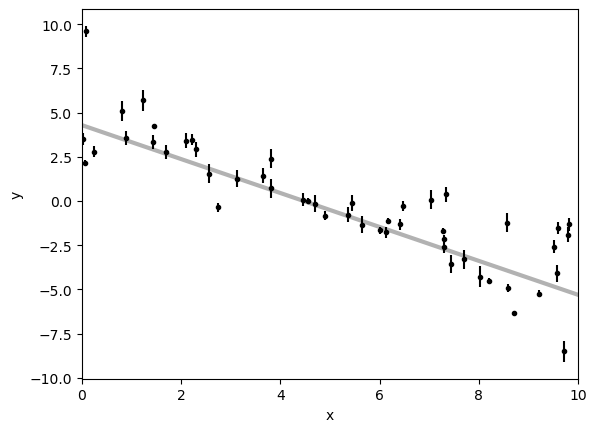

In [2]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [95]:
#def log_prior(theta):
#    m, b, log_f = theta
#    print(theta)
#    print(m.primal)
#    print(f'the type is {type(theta)}')
#    if -5.0 < m.primal < 0.5 and 0.0 < b.primal < 10.0 and -10.0 < log_f.primal < 1.0:
#        return 0.0
#    return -jnp.inf


def log_prior(theta):
    m, b, log_f = theta
    print(type(log_f.primal))
    if -5.0 < float(m.primal) < 0.5 and 0.0 < float(b.primal) < 10.0 and -10.0 < float(log_f.primal) < 1.0:
        return 0.0
    return -jnp.inf


def log_likelihood(theta, x=x, y=y, yerr=yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * jnp.exp(2 * log_f)
    return -0.5 * jnp.sum((y - model) ** 2 / sigma2 + jnp.log(sigma2))

def log_probability(theta, x=x, y=y, yerr=yerr):
    lp = log_prior(theta)
    if not jnp.isfinite(lp):
        return -jnp.inf
    return lp + log_likelihood(theta, x, y, yerr)

#def logdensity_fn(loc, log_scale, observed=observed):
#    """Univariate Normal"""
#    scale = jnp.exp(log_scale)
#    logpdf = stats.norm.logpdf(observed, loc, scale)
#    return jnp.sum(logpdf)


logdensity = lambda a: log_probability(**a)

In [96]:
inv_mass_matrix = np.array([0.01, 0.01, 0.01])
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

In [97]:
initial_position = {"theta": jnp.array([-1.0, 5.0, jnp.log(0.5)])}
initial_state = hmc.init(initial_position)
initial_state

<class 'jaxlib.xla_extension.ArrayImpl'>


HMCState(position={'theta': Array([-1.       ,  5.       , -0.6931472], dtype=float32)}, logdensity=Array(-42.359314, dtype=float32), logdensity_grad={'theta': Array([-93.92984  , -20.871183 ,   2.0367742], dtype=float32)})

In [98]:
hmc_kernel = jax.jit(hmc.step)

In [99]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [100]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, hmc_kernel, initial_state, 10_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = jnp.exp(states.position["log_scale"])

<class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=4/0)>
The problem arose with the `float` function. If trying to convert the data type of a value, try using `x.astype(float)` or `jnp.array(x, float)` instead.
The error occurred while tracing the function scanned_fun at /mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/lax/control_flow/loops.py:1668 for scan. This concrete value was not available in Python because it depends on the values of the arguments loop_carry[1].position['theta'], loop_carry[1].momentum['theta'], and loop_carry[1].logdensity_grad['theta'].

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

NameError: name 'loc_samples' is not defined

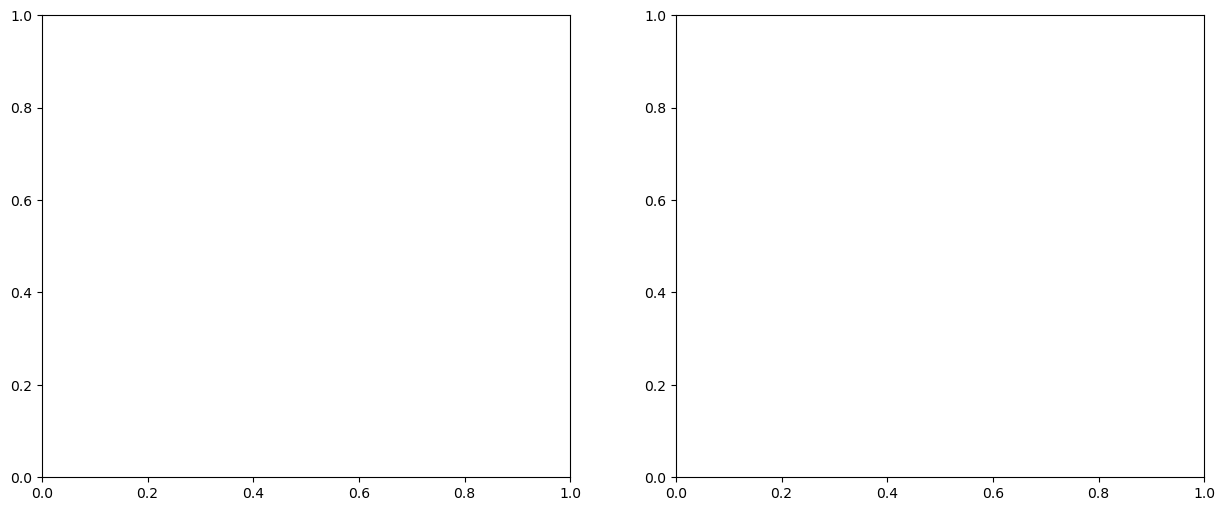

In [83]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(loc_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(scale_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale")

In [ ]:
inv_mass_matrix = np.array([0.5, 0.01])
step_size = 1e-3

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [ ]:
initial_position = {"loc": 1.0, "log_scale": 1.0}
initial_state = nuts.init(initial_position)
initial_state

In [ ]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, nuts.step, initial_state, 4_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = jnp.exp(states.position["log_scale"])

In [ ]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(loc_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(scale_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale")